In [1]:
import math 
import random 
import cv2
from PIL import Image
import pickle
import imageio
import cv2
import kornia as K
import kornia.geometry as KG
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from numpy.linalg import inv

In [7]:
# 2d image to 3D point, inversed intrinsic matrix
def image_to_point(image, intrinsic, depth_image):
    height, width = depth_image.shape[:2]
    fx = intrinsic[0,0]
    fy = intrinsic[1,1]
    cx = intrinsic[0,2]
    cy = intrinsic[1,2]
    skew = intrinsic[0,1]

    point1 = []
    color1 = []
    height, width = depth_image.shape[:2]
    inv_intrinsic = inv(intrinsic)
    for i in range(height):
        for j in range(width):
            point = (depth_image[i,j]*1000* np.array([i,j,1])).reshape(3, 1)
            point = inv_intrinsic @ point  #np.dot(inv_intrinsic, point)
            # point1.append(point)

            # if 0 <= point[0]/1000 < width and 0 <= point[1]/1000 < height:
            point1.append(point)
            color1.append(image[i][j])
    return np.array(point1),np.array(color1)

def inverse_E_point(point,extrinsic):
    if type(point) != np.ndarray:
        # print(point.shape)
        temp_p = torch.concat([point.reshape(-1,3),torch.ones(point.shape[0],1).to('cuda')],dim=1)
        inv_p = torch.inverse(extrinsic)@temp_p.T
        return inv_p[:3,:].T
    print(point.shape)
    temp_p = np.concatenate([point.reshape(-1,3), np.ones((point.shape[0], 1))], axis=1)
    inv_point = np.linalg.inv(extrinsic)@temp_p.T
    return inv_point.T[:, :3]

def point_to_image(point, intrinsic,height,width,color):
    perspective_projection = point/(point[:,[-1]])
    # print(perspective_projection.shape)
    projected_points = (intrinsic@perspective_projection.T).T
    image = projected_points[:, :2]
    rgbimage = np.zeros((height,width,3))
    print(projected_points.shape)
    color = color.reshape(-1,3)
    for i in range(image.shape[0]):
        try:
            rgbimage[image[i,0].astype(int),image[i,1].astype(int),:] = color[i]
        except:
            # print("image[{}]".format(i),image[i])
            continue

    return image,rgbimage

In [8]:

rec = np.load('data.npz', 'rb')
rec2 = np.load('data2.npz', 'rb')
rec3 = np.load('data3.npz', 'rb')
#

In [9]:
rgb_image1 = rec['rgb']
rgb_image2 = rec2['rgb']
rgb_image3 = rec3['rgb']
depth_image1 = rec['depth']
depth_image2 = rec2['depth']
depth_image3 = rec3['depth']
intrinsic = rec['K']
extrinsic1 = rec['extrinsic']
extrinsic2 = rec2['extrinsic']
extrinsic3 = rec3['extrinsic']


In [15]:
point1,color1 = image_to_point(rgb_image1,intrinsic,depth_image1)
point2,color2 = image_to_point(rgb_image2,intrinsic,depth_image2)
point3,color3 = image_to_point(rgb_image3,intrinsic,depth_image3)

In [12]:
import open3d as o3d
pcd_o3d = o3d.geometry.PointCloud()  
pcd_o3d.points = o3d.utility.Vector3dVector(point1.reshape(-1,3))
pcd_o3d.colors = o3d.utility.Vector3dVector(color1)  
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [156]:
#sanity check, recover image from itself
point1,color1 = image_to_point(rgb_image1,intrinsic,depth_image1)
point1_inv = inverse_E_point(point1,extrinsic1)
point1_project = extrinsic1@np.concatenate([point1_inv, np.ones((point1_inv.shape[0], 1))], axis=1).T
point1_project = point1_project.T[:, :3]
point_1_inverseE_projected,color1_projected = point_to_image(point1_project,intrinsic,rgb_image1.shape[0],rgb_image1.shape[1],color1)

(480000, 3, 1)
(480000, 3)
i 479999


In [188]:
point1.reshape(-1,3) - point1_project

array([[ 0.00000000e+00, -7.10542736e-15,  7.10542736e-15],
       [-1.42108547e-14,  0.00000000e+00,  0.00000000e+00],
       [ 7.10542736e-15,  0.00000000e+00,  7.10542736e-15],
       ...,
       [ 6.66133815e-16, -1.33226763e-15,  4.44089210e-16],
       [-1.11022302e-15,  4.44089210e-16,  4.44089210e-16],
       [-1.11022302e-15,  2.22044605e-15, -4.44089210e-16]])

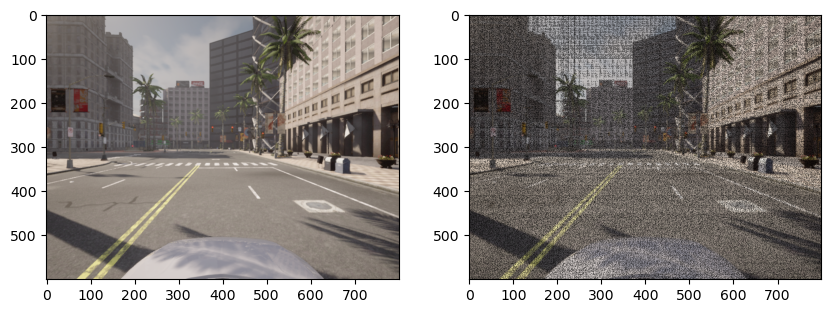

In [158]:
fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(rgb_image1)
ax[1].imshow(color1_projected)

In [17]:
def trainTqr(point1,point2,extrinsic1,extrinsic2):
    device = 'cuda'
    Tqr = torch.eye(4).to(device)
    Tqr.requires_grad = True
    loss_list = []
    optimizer = torch.optim.Adam([Tqr], lr=0.00005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    for epoch in range(1000):
        # print("epoch:",epoch)
        extrinsic1_tensor = torch.tensor(extrinsic1,dtype=torch.float32,requires_grad=False).to(device)
        p1_tensor = torch.tensor(point1,dtype=torch.float32,requires_grad=False).to(device)
        p2_tensor = torch.tensor(point2,dtype=torch.float32,requires_grad=False).to(device)
        
        worldpoint_1 = inverse_E_point(p1_tensor,extrinsic1_tensor)
        worldpoint_2 = inverse_E_point(p2_tensor,Tqr@extrinsic1_tensor)
        loss = torch.sum((worldpoint_1-worldpoint_2)**2)
        # print("loss:",loss)
        loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    return Tqr,loss_list

In [18]:
tqr_12,loss_12 = trainTqr(point1,point2,extrinsic1,extrinsic2)

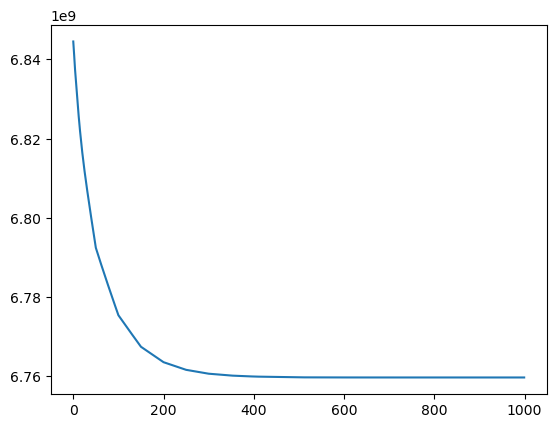

In [19]:
plt.plot(loss_12)
# loss still very high, I think it's because the light&shadows is not the same in the two images

In [189]:
tempq3 = (tqr_12.detach().cpu().numpy()@(np.concatenate([point1.reshape(-1,3), np.ones((point1.shape[0], 1))], axis=1).T)).T
tempq3 = tempq3[:, :3]/tempq3[:, [-1]]

tempp3Image,tempp3Image_color= point_to_image(tempq3,intrinsic,height=rgb_image2.shape[0],width = rgb_image2.shape[1],color =color1)

(480000, 3)
i 479999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


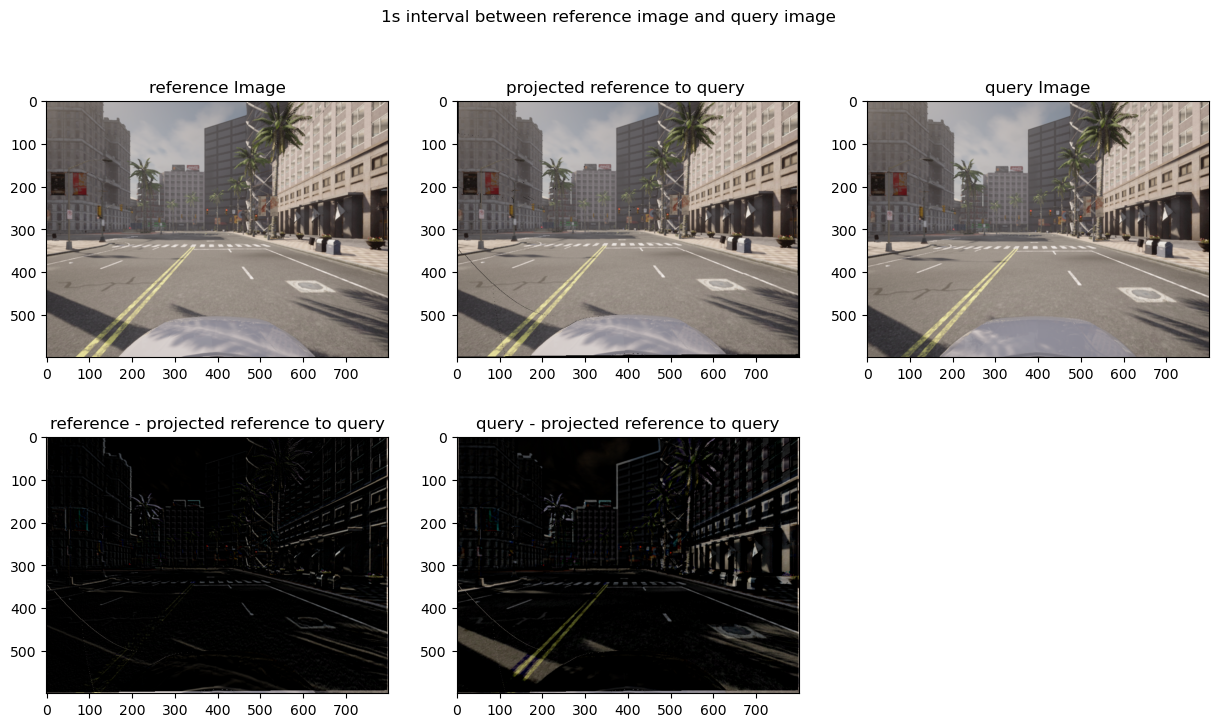

In [190]:
fig,ax = plt.subplots(2,3,figsize=(15,8))
ax[0,0].imshow(rgb_image1)
ax[0,0].set_title("reference Image")
ax[0,1].imshow(tempp3Image_color)
ax[0,1].set_title("projected reference to query ")
ax[0,2].imshow(rgb_image2)
ax[0,2].set_title("query Image")
ax[1,0].imshow(rgb_image1-tempp3Image_color)
ax[1,0].set_title("reference - projected reference to query")
ax[1,1].imshow(rgb_image2-tempp3Image_color)
ax[1,1].set_title("query - projected reference to query")
ax[1,2].axis('off')
# ax[1,2].imshow()

fig.suptitle("1s interval between reference image and query image")
fig.savefig("result_two_tick.png")

In [191]:
tqr_13,loss_13 = trainTqr(point1,point3,extrinsic1,extrinsic3)

im1to3 = (tqr_13.detach().cpu().numpy()@(np.concatenate([point1.reshape(-1,3), np.ones((point1.shape[0], 1))], axis=1).T)).T
im1to3 = im1to3[:, :3]/im1to3[:, [-1]]

im1to3_Image,im1to3_Image_color= point_to_image(im1to3,intrinsic,height=rgb_image3.shape[0],width = rgb_image3.shape[1],color =color1)

loss: tensor(5.2191e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tensor(5.2172e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tensor(5.2163e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tensor(5.2148e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tensor(5.2133e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tensor(5.2122e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tensor(5.2112e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tensor(5.2100e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tensor(5.2088e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tensor(5.2077e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tensor(5.2067e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tensor(5.2058e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tensor(5.2049e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tensor(5.2040e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tensor(5.2031e+09, device='cuda:0', grad_fn=<SumBackward0>)
loss: tens

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


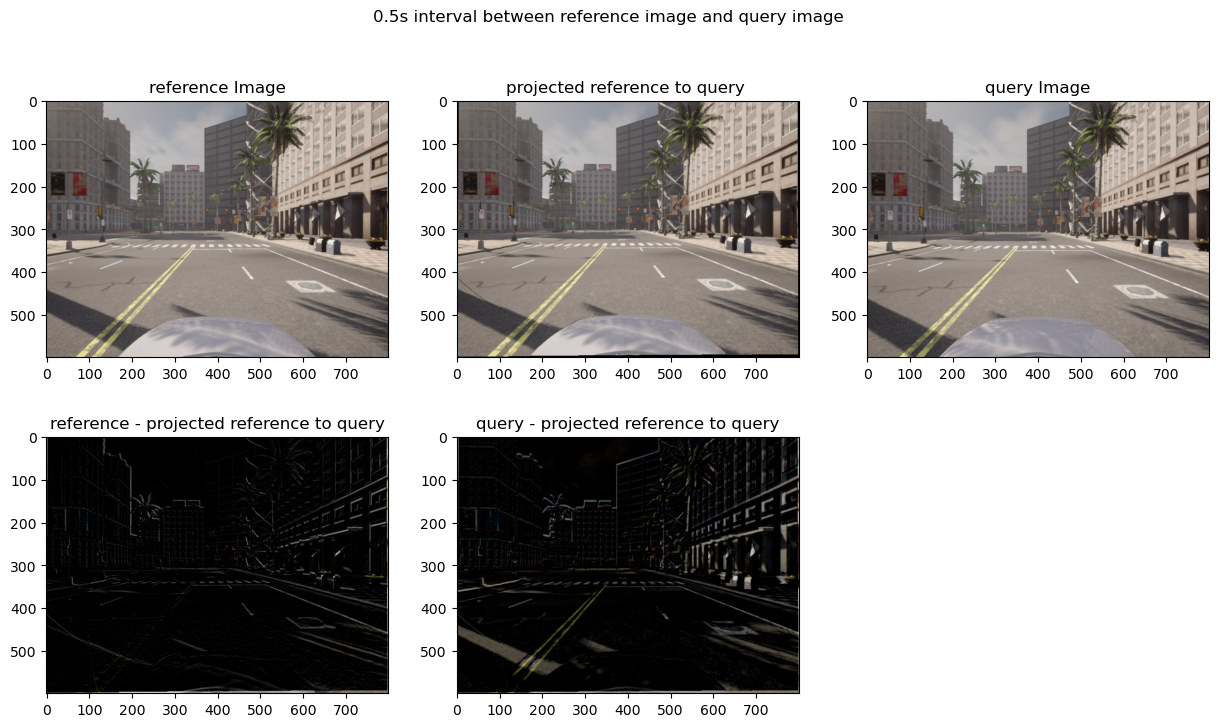

In [192]:
fig,ax = plt.subplots(2,3,figsize=(15,8))
ax[0,0].imshow(rgb_image1)
ax[0,0].set_title("reference Image")
ax[0,1].imshow(im1to3_Image_color)
ax[0,1].set_title("projected reference to query ")
ax[0,2].imshow(rgb_image3)
ax[0,2].set_title("query Image")
ax[1,0].imshow(rgb_image1-im1to3_Image_color)
ax[1,0].set_title("reference - projected reference to query")
ax[1,1].imshow(rgb_image3-im1to3_Image_color)
ax[1,1].set_title("query - projected reference to query")
ax[1,2].axis('off')
# ax[1,2].imshow()

fig.suptitle("0.5s interval between reference image and query image")
fig.savefig('result_one_tick.png')